In [6]:
# ! pip install lightning

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ExponentialLR
import torchvision
from torchvision import transforms, models, datasets
import torchmetrics
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint


In [2]:
PATH = '.'

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.2),
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.RandomAutocontrast(p=0.15),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0)
])

not_train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
batch_size = 32

train_dataset = datasets.ImageFolder(root=f"{PATH}/data/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f"{PATH}/data/val", transform=not_train_transforms)
test_dataset = datasets.ImageFolder(root=f"{PATH}/data/test", transform=not_train_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def calculate_class_weights_sklearn(dataset):
    y = np.array(dataset.targets)
    classes = np.unique(y)
    
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    
    return torch.FloatTensor(weights)

In [13]:
class ResNet50(L.LightningModule):
    def __init__(self, num_classes=10, lr=0.01, weight_decay=1e-4, class_weights=None):
        super(ResNet50, self).__init__()
        self.save_hyperparameters()
        
        self.model = models.resnet50(pretrained=True)
        
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        for param in list(self.model.parameters())[:-2]:
            param.requires_grad = False
            
        self._curr_epoch = 0
        self._unfrozen_layers = 0
        
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        
        self.lr = lr
        self.weight_decay = weight_decay
        self.class_weights = class_weights
        
        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.train_epoch_accs = []
        self.val_epoch_accs = []

        self.training_step_outputs = []
        self.validation_step_outputs = []
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        if self.class_weights is not None:            
            device_weight = self.class_weights.to(y.device)
            loss = F.cross_entropy(y_hat, y, weight=device_weight)
        else:
            loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc(y_hat.argmax(dim=1), y)
        
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)
        
        self.training_step_outputs.append({"loss": loss.detach(), "acc": acc.detach()})
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc(y_hat.argmax(dim=1), y)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        self.validation_step_outputs.append({"loss": loss.detach(), "acc": acc.detach()})

        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.training_step_outputs]).mean().item()
        avg_acc = torch.stack([x["acc"] for x in self.training_step_outputs]).mean().item()
        
        self.train_epoch_losses.append(avg_loss)
        self.train_epoch_accs.append(avg_acc)

        self.training_step_outputs.clear()
        
        if self._curr_epoch >= 5:
            modules_to_unfreeze = [
                self.model.layer4,
                self.model.layer3,
                self.model.layer2,
                self.model.layer1,
                self.model.conv1
            ]
            
            layer_to_unfreeze = self._curr_epoch - 5
            
            if layer_to_unfreeze < len(modules_to_unfreeze) and layer_to_unfreeze > self._unfrozen_layers:
                print(f"Розморожуємо шар {layer_to_unfreeze+1} з {len(modules_to_unfreeze)}")
                for param in modules_to_unfreeze[layer_to_unfreeze].parameters():
                    param.requires_grad = True
                self._unfrozen_layers = layer_to_unfreeze
        
        self._curr_epoch += 1

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.validation_step_outputs]).mean().item()
        avg_acc = torch.stack([x["acc"] for x in self.validation_step_outputs]).mean().item()
        
        self.val_epoch_losses.append(avg_loss)
        self.val_epoch_accs.append(avg_acc)

        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        scheduler = ExponentialLR(optimizer, gamma=0.9)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def plot_metrics(self):
        if len(self.train_epoch_losses) == 0 or len(self.val_epoch_losses) == 0:
            return

        min_len = min(len(self.train_epoch_losses), len(self.val_epoch_losses))

        train_losses = self.train_epoch_losses[:min_len]
        val_losses = self.val_epoch_losses[:min_len]
        train_accs = self.train_epoch_accs[:min_len]
        val_accs = self.val_epoch_accs[:min_len]

        epochs = np.arange(1, min_len + 1)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, train_losses, "bo-", label="Train Loss")
        plt.plot(epochs, val_losses, "ro-", label="Val Loss")
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, train_accs, "bo-", label="Train Acc")
        plt.plot(epochs, val_accs, "ro-", label="Val Acc")
        plt.title("Accuracy per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        
        plt.subplot(1, 3, 3)
        all_preds = []
        all_targets = []
        self.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(self.device)
                y_hat = self(x)
                preds = y_hat.argmax(dim=1).cpu()
                all_preds.extend(preds.numpy())
                all_targets.extend(y.numpy())
        
        cm = confusion_matrix(all_targets, all_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()

In [14]:
weights = calculate_class_weights_sklearn(
    train_dataset
)

model = ResNet50(num_classes=4, lr=10e-4, weight_decay=10e-4, class_weights=weights)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    filename='resnet50-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

trainer = L.Trainer(
    max_epochs=25,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping],
    log_every_n_steps=1
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 23.5 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
8.2 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB)
153       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Розморожуємо шар 2 з 5


Validation: |          | 0/? [00:00<?, ?it/s]

Розморожуємо шар 3 з 5


Validation: |          | 0/? [00:00<?, ?it/s]

Розморожуємо шар 4 з 5


Validation: |          | 0/? [00:00<?, ?it/s]

Розморожуємо шар 5 з 5


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

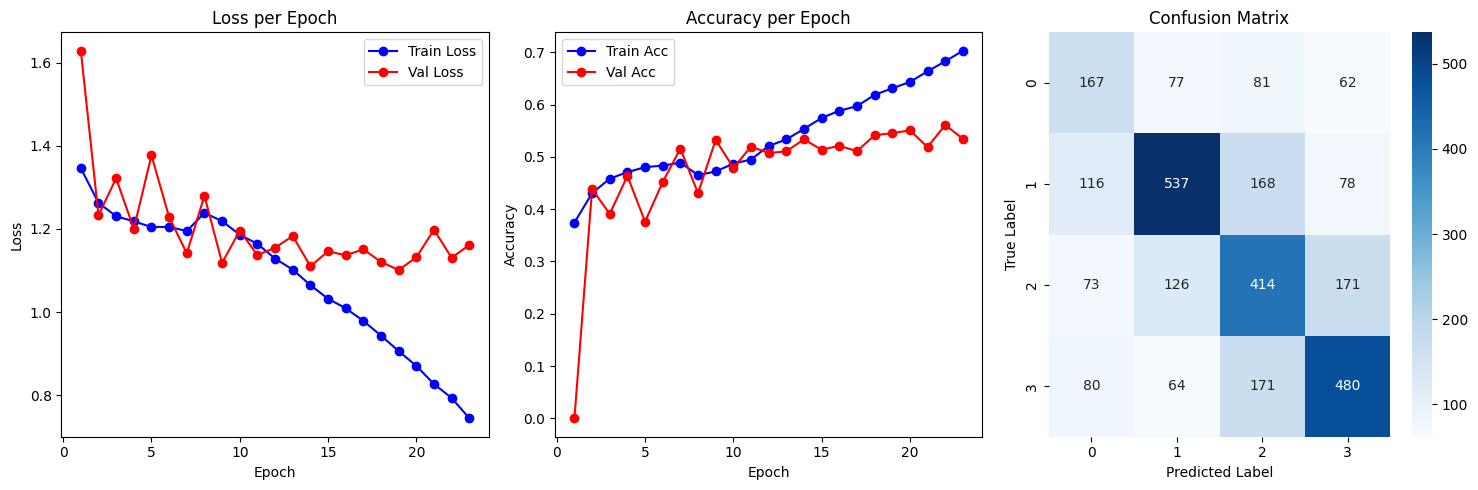

In [16]:
model.plot_metrics()